# Data analysis

In [2]:
import math
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict
import csv
from typing import NamedTuple
from scipy.spatial import distance
from collections import defaultdict
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
Vector = List[float]
pd.options.mode.chained_assignment = None 

In [3]:
original = pd.read_csv("vehicles.csv", engine = "python", encoding = "latin1")
#########
usedcars = original[["price", "year", "manufacturer", "condition", "cylinders", "odometer", "title_status", "transmission", "drive", "type"]]
#########

In [4]:
#Consider only values which are finite, aka have no NaN value
newUsedCars = usedcars.dropna()

def find_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df.drop(df[(df[column] < lower_bound)].index, inplace = True)
    df.drop(df[(df[column] > upper_bound)].index, inplace = True)
    
find_outliers_iqr(newUsedCars, 'price')
find_outliers_iqr(newUsedCars, 'odometer')
find_outliers_iqr(newUsedCars, 'year')

##Turns string to int value
le = LabelEncoder()
newUsedCars['conditionint'] = le.fit_transform(newUsedCars['condition'])
newUsedCars["title_statusint"] = le.fit_transform(newUsedCars["title_status"])
newUsedCars["transmissionint"] = le.fit_transform(newUsedCars["transmission"])
newUsedCars["manufacturerint"] = le.fit_transform(newUsedCars["manufacturer"])
newUsedCars["cylindersint"] = le.fit_transform(newUsedCars["cylinders"])
newUsedCars["driveint"] = le.fit_transform(newUsedCars["drive"])
newUsedCars["typeint"] = le.fit_transform(newUsedCars["type"])

## Bar Chart for relating the condition of a car and its price

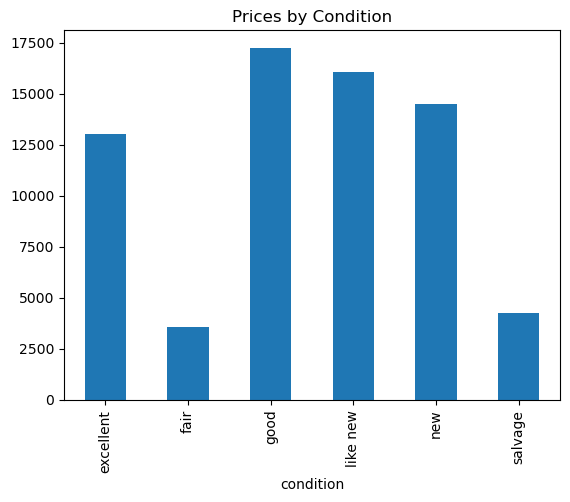

In [6]:
MeanPriceByCondition = newUsedCars.groupby(["condition"])["price"].mean().plot(kind="bar", title="Prices by Condition")

#### As seen by this graph, the median value of a car seems to decrease as its condition gets worse, though one exception is the good category, which has a higher median price than the other categories even though its quality is not as good. This is most likely a result of most cars being listed as "good", at least compared to other variables

<Axes: title={'center': 'Prices by Car Status'}, xlabel='title_status'>

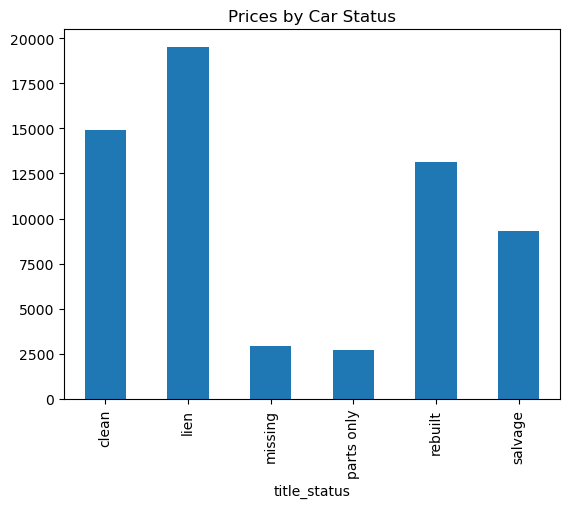

In [8]:
newUsedCars.groupby(["title_status"])["price"].mean().plot(kind="bar", title="Prices by Car Status")

#### There isn't much difference between the mean prices of the types of transmissions, though cars with alternative transmissions are more valuable overall.

<Axes: title={'center': 'Prices by Transmission Type'}, xlabel='transmission'>

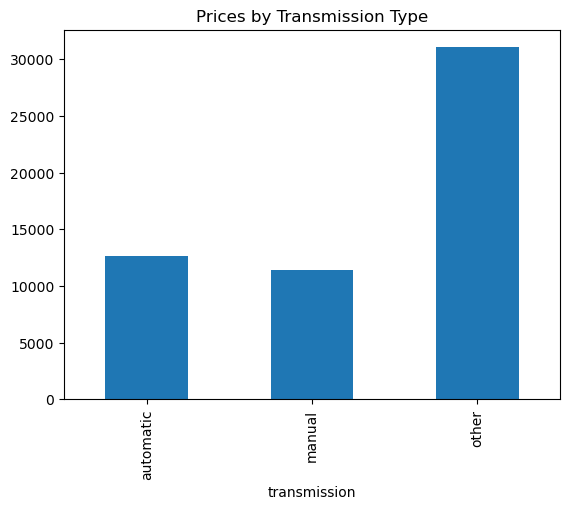

In [10]:
newUsedCars.groupby(["transmission"])["price"].mean().plot(kind="bar", title="Prices by Transmission Type")

#### There isn't much difference between the mean prices of the types of transmissions, though cars with alternative transmissions are more valuable overall.

<Axes: title={'center': 'Prices by Manufacturer'}, xlabel='manufacturer'>

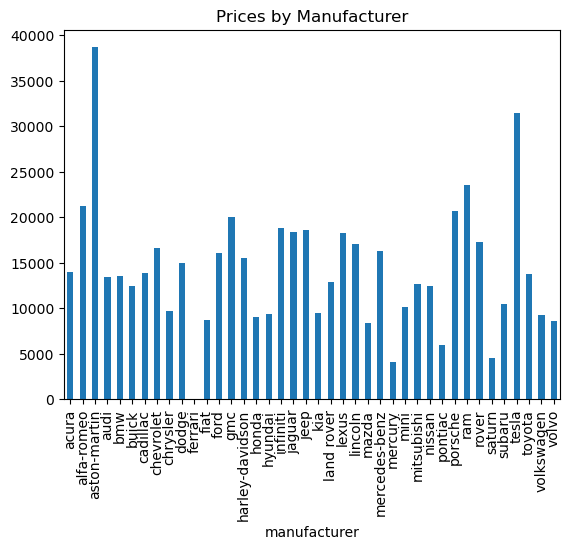

In [12]:
newUsedCars.groupby(["manufacturer"])["price"].mean().plot(kind="bar", title="Prices by Manufacturer")

#### There are strong differences among the mean prices of cars by their manufacutrer. Generally more high-class manufactuers like Alfa-Romeo and Aston-Martin are far more valuable than more general car manufacturers like Chevrolet and Ford.

<Axes: title={'center': 'Prices by Number of Cylinders'}, xlabel='cylinders'>

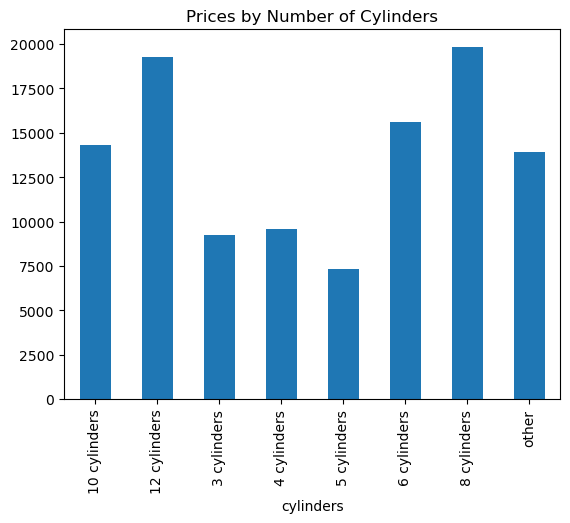

In [14]:
newUsedCars.groupby(["cylinders"])["price"].mean().plot(kind="bar", title="Prices by Number of Cylinders")

#### Though both 10-cylinder and 5-cylinder cars break from this trend, the mean price of a car generally increases as the number of cylinders increases giving a somewhat linear relationship between cylinders and prices.

<Axes: title={'center': 'Prices by Their Type of Drive'}, xlabel='drive'>

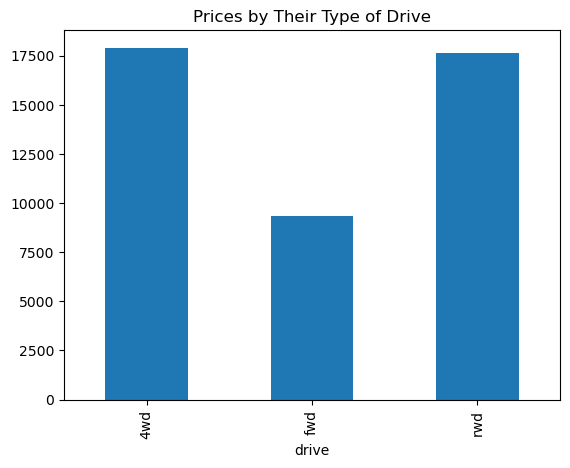

In [16]:
newUsedCars.groupby(["drive"])["price"].mean().plot(kind="bar", title="Prices by Their Type of Drive")

#### Cars which have a forward wheel drive have far lower mean prices than cars with a rear wheel or 4 wheel drive

<Axes: title={'center': 'Prices by the type of car'}, xlabel='type'>

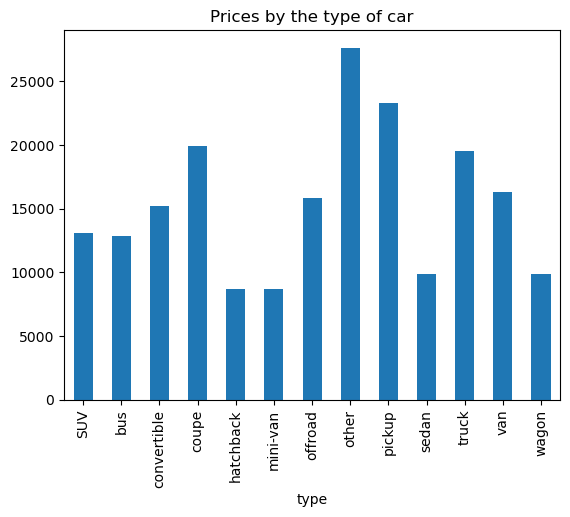

In [18]:
newUsedCars.groupby(["type"])["price"].mean().plot(kind="bar", title="Prices by the type of car")

#### Mean prices differ heavily based on what type a specific car is, ranging from hatchbacks and mini-vans to coupes and pickups, the differences in types should be a good indicator of a specific car's value.

## Scatterplot between the quantitative inputs and the resulting price

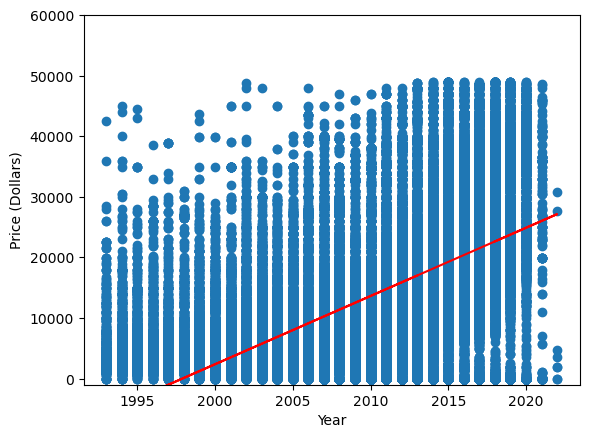

In [21]:
#Setting up a scatter plot between the year and the price
fig, ax = plt.subplots()
year = newUsedCars["year"]
price = newUsedCars["price"]
ax.scatter(year, price)

# Creating a regression line to show the trend

m, b = np.polyfit(year, price, deg=1)
ax.plot(year, m * year + b, color="red")
#labels
plt.xlabel("Year")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view
plt.ylim(-1000, 60000)
plt.show()


#### Looking at this graph, there seems to be a slightly positive relationship between the year and the price. There is a strong positve linear relationship between the age of a car and its price, showing that age is a good indicator of price and a valuable input for our model.

## Plotting the relationship between the mileage and the price

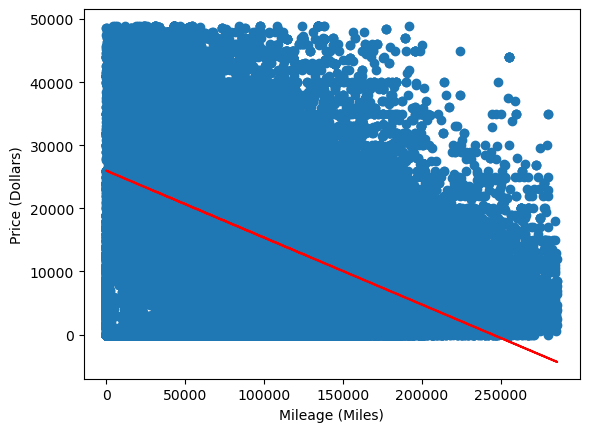

In [24]:
#Setting up a scatter plot between the mileage and the price
fig, ax = plt.subplots()
mileage = newUsedCars["odometer"]
price = newUsedCars["price"]

#plotting the line
ax.scatter(mileage, price)

# Creating a regression line to show the trend
m, b = np.polyfit(mileage, price, deg=1)
ax.plot(mileage, m * mileage + b, color="red")
#labels
plt.xlabel("Mileage (Miles)")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view

plt.show()

#### Unlike the relationship between the year and the price, the relationship between the mileage of a car and its price is negative, meaning that the more a car has been driven, the lower its price becomes. The strongly downward sloping nature of the regression line means mileage is a valuable metric to judge a car's price

## Heat Map of Correlations

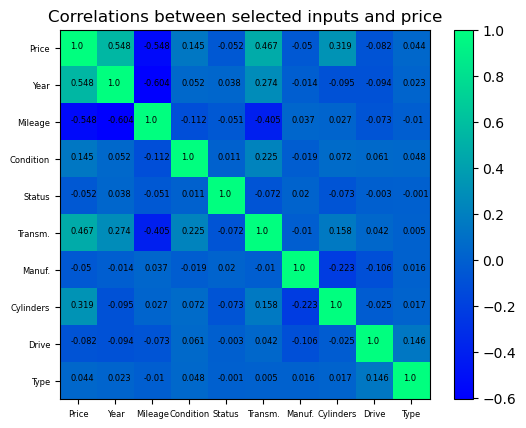

In [27]:
#Correlating each relevant category with others
correlations = newUsedCars[["price", "year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]].corr()
#Setting the axes up (Transm. = Transmission and Manuf. = Manufacturer, reduced to avoid word overlap)
ax = plt.axes()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)

#Setting the title
plt.title("Correlations between selected inputs and price")
plt.imshow(correlations, cmap="winter")
plt.colorbar()
#Putting the actual correlation coefficients with their respective correlation
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(correlations.values[i][j], 3)), xy=(j - 0.225, i), fontsize=6)

#### The correlation matrix shows which inputs have the most impact on price and, as a result, which inputs will be the most valuable to improving our dataset. Variables with a higher absolute correlation, like the Year and Mileage, have a far greater impact on predictions than less correlative variables like the Status and Manufacturer of the car

### Box Plot for price

Text(0.5, 1.0, 'Boxplot for the price of used cars')

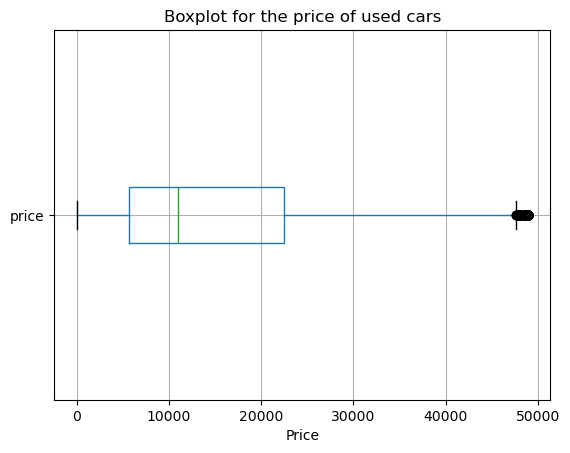

In [30]:
newUsedCars.boxplot(column=["price"], vert=False, xlabel="Price")
plt.title("Boxplot for the price of used cars")

#### As shown by the boxplot, when major outliers are removed from the data set, the price of most cars tends to sit in the 10,000 to 20,000 dollar range. The data is somewhat skewed right, but not to a troubling extent that can get in the way of accurate testing.

# Quadratic Regression(Roshan)

In [33]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [34]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

In [35]:
print(f'Root mean squared error: {root_mean_squared_error(testerYPredictions, testerY)}')
print(f'Mean absolute error: {mean_absolute_error(testerYPredictions, testerY)}')
#print(f'Correlation coefficients: {polyM.coef_}')
print(f'R-Squared: {r2_score(testerYPredictions, testerY)}')

Root mean squared error: 7087.188098142315
Mean absolute error: 4662.93967035902
R-Squared: 0.42776716121811764


# Lasso Regression (Rachel)

For Lasso Regression I will create two models, one with all features and one with only the features with high correlations to price.

The 3 features with the most correlation are:
- Mileage
- Transmission
- Year

In [90]:
lass = Lasso()
lass.fit(trainerX, trainerY)
print(lass.intercept_)
print(lass.coef_)
lassPredict = lass.predict(testerX)
print("Score ", root_mean_squared_error(testerY, lassPredict))
print(f'R-Squared: {r2_score(testerY, lassPredict)}')


print()
print()
refinedInput = newUsedCars[["year", "odometer","transmissionint"]]
rtrainerX, rtesterX, rtrainerY, rtesterY = train_test_split(refinedInput, Price, test_size=0.2, random_state=27)

rlass = Lasso()
rlass.fit(rtrainerX, rtrainerY)
print(rlass.intercept_)
print(rlass.coef_)
rlassPredict = rlass.predict(rtesterX)
print("Score ", root_mean_squared_error(rtesterY, rlassPredict))
print(f'R-Squared: {r2_score(rtesterY, rlassPredict)}')

-1478237.3020544886
[ 7.37249413e+02 -5.09047985e-02  3.11016397e+02 -5.44769289e+02
  3.60406777e+03  3.70176839e+01  3.05112179e+03 -1.10890427e+03
  1.03409761e+02]
Score  7852.91378208343
R-Squared: 0.5536223191787815


-1346965.2693754986
[ 6.78792376e+02 -4.53474168e-02  4.98685385e+03]
Score  8806.798264638132
R-Squared: 0.43859418182319687


**My theory that less criterias would lead to a higher R-Squared value was wrong.**

My finding with Lasso Regression is that there is a 55% accuracy with this models output. Because Lasso experiences hardly any changes when tuning is done though the changing of hyperparameters, I will not be changing the alpha in attempts to make the model more accurate. 

**However, improvements can be made with data scaling**